In [1]:
# 主要包
import numpy as np
import pandas as pd
# 绘图
import seaborn as sns
import matplotlib.pyplot as plt
# 模型
# 集成学习 RF GDBT
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# 线性回归 Ridge 和ElasticNet
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
# 支持向量机
from sklearn.svm import SVR
# skew度量倾斜度(偏度)(三阶中心距),和正态化
from scipy.stats import skew, norm
# scipy中的方法
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
# 网格搜索最优模型
from sklearn.model_selection import GridSearchCV
# 交叉验证,交叉验证的评估分数
from sklearn.model_selection import KFold, cross_val_score
# mse
from sklearn.metrics import mean_squared_error
# 将分类整数特征编码为即“one-of-K”或“dummy”
from sklearn.preprocessing import OneHotEncoder
# 它还可以用于将非数字标签(只要它们是可耐洗和可比较的)转换为数字标签。
from sklearn.preprocessing import LabelEncoder
# 生成管道
from sklearn.pipeline import make_pipeline
# StandardScaler和scale的区别是使用StandardScaler会保留测试集合均值和标准差同样在测试集上进行标准化
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
# 使用对异常值具有鲁棒性的统计数据来缩放特性。
from sklearn.preprocessing import RobustScaler
# 降维
from sklearn.decomposition import PCA

# 忽略警告
import warnings
warnings.filterwarnings(action="ignore")

G:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# 加载数据集
train = pd.read_csv('input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('input/house-prices-advanced-regression-techniques/test.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# 让数据拟合正态分布
train["SalePrice"] = np.log1p(train["SalePrice"])

In [4]:
# 去除噪声点
train.drop(train[(train['OverallQual']<5) & (train['SalePrice']>200000)].index, inplace=True)
train.drop(train[(train['GrLivArea']>4500) & (train['SalePrice']<300000)].index, inplace=True)
# 去除后更新索引
train.reset_index(drop=True, inplace=True)

In [5]:
# 分割特征和标签
# 设置SalePrice为标签
train_labels = train['SalePrice'].reset_index(drop=True)
# 移除SalePrice后的剩余属性设置为特征
train_features = train.drop(['SalePrice'], axis=1)
test_features = test
# 结合训练和测试的特征，以便将整个数据集在管道中应用
all_features = pd.concat([train_features, test_features]).reset_index(drop=True)
all_features.shape

(2917, 80)

In [6]:
# 一些非数字数据存储为数字;把它们转换成字符串 apply可以直接进行转换
all_features['MSSubClass'] = all_features['MSSubClass'].apply(str)
all_features['YrSold'] = all_features['YrSold'].astype(str)
all_features['MoSold'] = all_features['MoSold'].astype(str)

In [7]:
def handle_missing(features):
    # 数据描述说明NA引用典型('Typ')值
    features['Functional'] = features['Functional'].fillna('Typ')
    # 用它们的模式替换下面每一列中缺失的值
    features['Electrical'] = features['Electrical'].fillna("SBrkr")
    features['KitchenQual'] = features['KitchenQual'].fillna("TA")
    features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
    features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
    features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])
    features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
    
    # NA引用“No Pool”的数据描述统计信息
    features["PoolQC"] = features["PoolQC"].fillna("None")
    # 用0替换缺失的值，因为没有garage =车库中没有汽车
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
        features[col] = features[col].fillna(0)
    # 将丢失的数据设置为None
    for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
        features[col] = features[col].fillna('None')
    # NaN values for these categorical basement features, means there's no basement
    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
        features[col] = features[col].fillna('None')
        
    # 按照neighborhoods分组, 并按照neighborhood的LotFrontage 的中值进行填充
    features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

    # 对于如何填充其余的分类特征，我们没有特别的直觉
    # 所以我们用None替换它们缺失的值
    objects = []
    for i in features.columns:
        if features[i].dtype == object:
            objects.append(i)
    features.update(features[objects].fillna('None'))
    # 我们对数值特征做同样的处理，但这次填充的是0
    numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numeric = []
    for i in features.columns:
        if features[i].dtype in numeric_dtypes:
            numeric.append(i)
#     将特征中存在的类型添加到numeric中，将这些属性的特征中确实的值填入0
    features.update(features[numeric].fillna(0))    
    return features

all_features = handle_missing(all_features)

In [8]:
data = pd.DataFrame(all_features)
df_cols = list(pd.DataFrame(data))
dict_x = {}
for i in range(0, len(df_cols)):
    # round 可以进行四舍五入，这里我们对每一列的空值进行均值化，算出百分比
    dict_x.update({df_cols[i]: round(data[df_cols[i]].isnull().mean()*100,2)})
dict_x

{'1stFlrSF': 0.0,
 '2ndFlrSF': 0.0,
 '3SsnPorch': 0.0,
 'Alley': 0.0,
 'BedroomAbvGr': 0.0,
 'BldgType': 0.0,
 'BsmtCond': 0.0,
 'BsmtExposure': 0.0,
 'BsmtFinSF1': 0.0,
 'BsmtFinSF2': 0.0,
 'BsmtFinType1': 0.0,
 'BsmtFinType2': 0.0,
 'BsmtFullBath': 0.0,
 'BsmtHalfBath': 0.0,
 'BsmtQual': 0.0,
 'BsmtUnfSF': 0.0,
 'CentralAir': 0.0,
 'Condition1': 0.0,
 'Condition2': 0.0,
 'Electrical': 0.0,
 'EnclosedPorch': 0.0,
 'ExterCond': 0.0,
 'ExterQual': 0.0,
 'Exterior1st': 0.0,
 'Exterior2nd': 0.0,
 'Fence': 0.0,
 'FireplaceQu': 0.0,
 'Fireplaces': 0.0,
 'Foundation': 0.0,
 'FullBath': 0.0,
 'Functional': 0.0,
 'GarageArea': 0.0,
 'GarageCars': 0.0,
 'GarageCond': 0.0,
 'GarageFinish': 0.0,
 'GarageQual': 0.0,
 'GarageType': 0.0,
 'GarageYrBlt': 0.0,
 'GrLivArea': 0.0,
 'HalfBath': 0.0,
 'Heating': 0.0,
 'HeatingQC': 0.0,
 'HouseStyle': 0.0,
 'Id': 0.0,
 'KitchenAbvGr': 0.0,
 'KitchenQual': 0.0,
 'LandContour': 0.0,
 'LandSlope': 0.0,
 'LotArea': 0.0,
 'LotConfig': 0.0,
 'LotFrontage': 0.0,


In [9]:
# 获取所有数值特征
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in all_features.columns:
    if all_features[i].dtype in numeric_dtypes:
        numeric.append(i)
# 找到扭曲的数值特征
skew_features = all_features[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features.head(10)

There are 25 numerical features with Skew > 0.5 :


MiscVal          21.939672
PoolArea         17.688664
LotArea          13.109495
LowQualFinSF     12.084539
3SsnPorch        11.372080
KitchenAbvGr      4.300550
BsmtFinSF2        4.144503
EnclosedPorch     4.002344
ScreenPorch       3.945101
BsmtHalfBath      3.929996
dtype: float64

In [10]:
# Normalize倾斜的特性
for i in skew_index:
    # boxcoxlp变换可以保证线性回归满足独立，线性，齐性，正态性的同时，不丢失信息
    # 总而言之就是将数据正态化
#     all_features[i] = boxcox1p(all_features[i], boxcox_normmax(all_features[i] + 1))

In [11]:
all_features = pd.get_dummies(all_features).reset_index(drop=True)
all_features.shape

(2917, 333)

In [12]:
X = all_features.iloc[:len(train_labels), :]
X_test = all_features.iloc[len(train_labels):, :]
X.shape, train_labels.shape, X_test.shape

((1458, 333), (1458,), (1459, 333))

In [13]:
# 设置交叉验证折叠
kf = KFold(n_splits=4, random_state=42, shuffle=True)
# 定义误差评定指标
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, train_labels, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

In [14]:
# Ridge Regressor
ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kf))

# Support Vector Regressor
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))

# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)  

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=1200,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42)

In [15]:
scores = {}
score = cv_rmse(svr)
print("SVR: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['svr'] = (score.mean(), score.std())
score = cv_rmse(ridge)
print("ridge: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['ridge'] = (score.mean(), score.std())
score = cv_rmse(rf)
print("rf: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['rf'] = (score.mean(), score.std())
score = cv_rmse(gbr)
print("gbr: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['gbr'] = (score.mean(), score.std())

SVR: 0.1108 (0.0115)
ridge: 0.1117 (0.0089)
rf: 0.1411 (0.0097)
gbr: 0.1142 (0.0084)


In [17]:
print('Svr')
svr_model_full_data = svr.fit(X, train_labels)
print('Ridge')
ridge_model_full_data = ridge.fit(X, train_labels)
print('RandomForest')
rf_model_full_data = rf.fit(X, train_labels)
print('GradientBoosting')
gbr_model_full_data = gbr.fit(X, train_labels)

Svr
Ridge
RandomForest
GradientBoosting


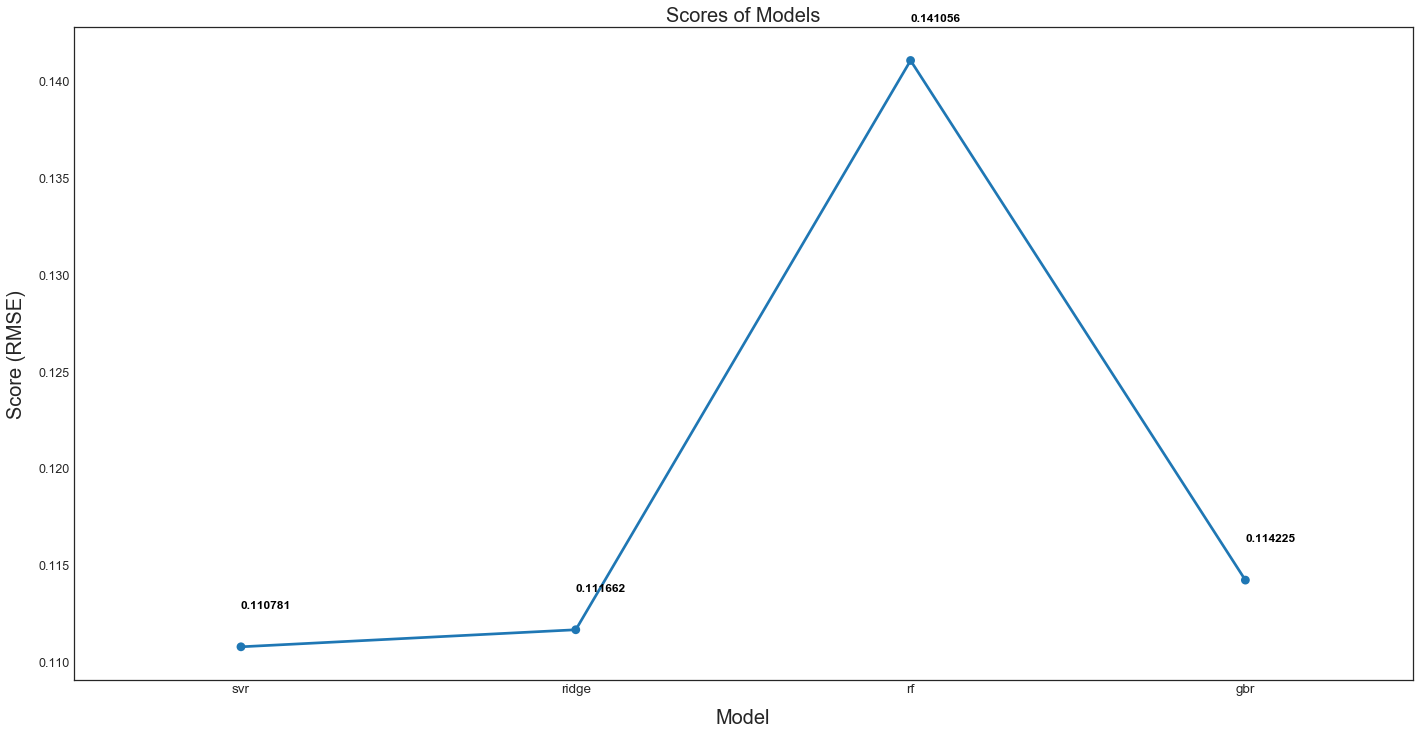

In [19]:
sns.set_style("white")
fig = plt.figure(figsize=(24, 12))

ax = sns.pointplot(x=list(scores.keys()), y=[score for score, _ in scores.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(scores.values()):
    ax.text(i, score[0] + 0.002, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Score (RMSE)', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Scores of Models', size=20)

plt.show()

In [22]:
def blended_predictions(X):
    return ((0.1 * ridge_model_full_data.predict(X)) + \
            (0.2 * svr_model_full_data.predict(X)) + \
            (0.15 * gbr_model_full_data.predict(X))+ \
            (0.55 * rf_model_full_data.predict(X)))
# Get final precitions from the blended model
blended_score = rmsle(train_labels, blended_predictions(X))
scores['blended'] = (blended_score, 0)
print('RMSLE score on train data:')
print(blended_score)

RMSLE score on train data:
0.07898517714469282


In [23]:
# 读取sample_submission的数据
submission = pd.read_csv("input/house-prices-advanced-regression-techniques/sample_submission.csv")
# 添加来自混合模型的预测
submission.iloc[:,1] = np.floor(np.expm1(blended_predictions(X_test)))
# 修复不着边的预测
q1 = submission['SalePrice'].quantile(0.0045)
q2 = submission['SalePrice'].quantile(0.99)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.77)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)
submission.to_csv("submission_regression1.csv", index=False)
# 规模预测
submission['SalePrice'] *= 1.001619
submission.to_csv("submission_regression2.csv", index=False)
submission.shape

(1459, 2)